# The Monty Hall Problem

---
---

## Introduction 

The famous "Monty Hall Problem" is a well-known example of the role of conditional problem that was made popular by the television game show *Let's Make a Deal*. In the problem, an individual is presented with a collection of three doors, behind one of which is a prize. The Individual is told to select one of these three doors, after which, the host opens one of the remaining unselected doors, showing that the prize is not behind said door. The individual is then asked if they would like to remain with their initial selection or switch to the remaining closed door that they did not originally select. The problem then is simply to determine if the individual should remain with their original door or swap to the remaining choice. 

While during the time of *Let's Make a Deal*, this problem resulted in a large amount of contention, particularly after the columnist Marilyn vos Savant wrote, in *Parade* magazine, that one should switch doors in the problem with her simple and very correct explanation. The magazine received approximately 10,000 letters, including a large portion of Ph.Ds., largely complaining that her explanation and solution were incorrect.

The solution proposed by Savant was a simple explanation that can be formally described using the condition problem, and is as follows:

1. The individual selects one of the three doors, let's call this door 1. The probability that door 1 has the prize behind it is $1/3$, meaning that the probability that the door does not have the prize is $1 - 1/3 = 2/3$.


2. Next, the host removes one of the remaining doors, say door 2. It is a rule of the game and an assumption of the problem that the host only removes a door that does not have the prize. Therefore, door 2 necessarily doesn't have the prize. Then the individual is prompted with the choice to change doors.


3. There are now two doors remaining. Door 1, selected by the individual, which has a probability of $1/3$ to contain the prize and $2/3$ that it does not, and Door 3, which has a probability of will have probabilities $1-1/3=2/3$ of containing the prize and $1-2/3=1/3$ of not containing the prize. Note that these are the conditional probabilities given that the initial choice was made.  

Therefore, we are left that switching doors leads to a higher probability of a favorable outcome for exactly the reason that you were less likely to guess the correct door initially.


References statement:

While the following code was written and prepared by me, the above historical details were collected from Wikipedia and can be found, along with many others, here: [Wiki: Monty Hall Problem](https://en.wikipedia.org/wiki/Monty_Hall_problem#Solutions_using_conditional_probability_and_other_solutions)

--- 

## The purpose of this notebook

If anyone is to stumble upon this notebook on my GitHub account, they may ask, "Why did you write this if this is already well understood?". Well, as mentioned in the introduction, this solution caused considerable confusion and contention from readers of Savant's column, even from many mathematicians. This includes the famous example of Paul Erdos, who only believed the result after seeing the results of numerical simulation. One would think that this matter had long been brought to rest; however, several months back, I was at a party. Among others, the guest list of this party included, including myself, 3 Ph.D. mathematicians, at least 2 holders of M.S. in applied mathematics, and several other highly educated individuals. A friend of one of these guests was very insistent that the well-accepted solution to the Monty Hall Problem was incorrect, despite receiving an explanation from just about every one of us. He was also very against creating a simulation of the result to see for himself that he was wrong. So here I am, about 7:00 pm on a holiday, putting the finishing touches on this notebook that contains a simulation of the Monty Hall problem compared with the theoretical result and a small mound of evidence that Savant's solution is correct. Hopefully, if you are ever so unfortunate as to run into an individual who refuses to believe Savant's solution, then you might find this notebook and be able to show them otherwise. Not that they are likely to believe me either. So good luck.

Dr. Corbit R. Sampson

--- 

## The content of this notebook

The following code block contains the necessary code to run a simulation of the Monty Hall problem for a user-selected sample size and number of samples. There is minor functionality to include more than 3 total doors. 

The primary run function is titled `main`. Note the code block below, as limited additional comments to explain details. Running the main function with `NumTrails = 1000` and `NumSamples = 1000` will cause 2000 simulations (1000 with door swaps 1000 without), each containing 1000 trails of the random process, plot the success and failure rates with and without door swaps and show the predicted values from the theory as dashed black lines. Additionally, the bar graph includes the $5\%$ confidence interval, assuming that the distribution of the samples is normal about the mean. Note that while `main` works from an arbitrary number of doors, the theory that was included in this function assumes only a SINGLE prize and will not produce the correct result.

In case anyone that you might be showing these simulations to doubts that the samples are normally distributed about the mean, and thus the selected method of creating the $5/%$ confidence interval would be a poor choice, the function `show_stat_fit` produces histograms of the outcome, with and without door swaps, and a normal distribution with the mean and standard deviation equal to the sample mean and sample standard deviation to see that this is an adequate distribution.

Lastly, the function `show_stat_fit` includes a brief analysis of what happens for a single prize behind an arbitrary number of doors, with and without door swaps. Particularly, showing that as the number of doors increases, the decision to swap doors begins to become moot, provided only a single door is taken away.

---

## uses

The intended uses for this notebook are exactly what I described above, to provide just a little more evidence to those who refuse to accept the long, long accepted solution to the Monty Hall Problem. In addition to this, please use the code to learn whatever you can from it, while that may be quite minor.

---


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import random
from matplotlib.ticker import PercentFormatter
from IPython.display import display, Latex
from scipy import stats
from scipy.stats import t
from scipy.optimize import curve_fit

font = {'size':16}
plt.rcParams['text.usetex'] = True
plt.rc('font',**font)

class agent:
# agent object. upon initalization
# an agent will have a collection of doors and the option 
# to switch doors when presented with the choice.
    
    def __init__(self, Doors, SwitchDoors):
        # Doors, a numpy array holding the states of the doors where a 0 indicates no prize and 1 prize.
        # SwitchDoors, a boolean represent if the agent will switch doors.
        
        self.Doors = np.array(Doors)
        self.Guess = random.randrange(Doors.size) # initial guess
        self.Outcome = Doors[self.Guess] # The outcome. 1 indicating success and 0 failure.
        self.WillSwitch = SwitchDoors 
        
    def RemoveDoor(self):
        # this method removes one of the doors that the individual will select 
        # from when given the option to reselected.
            self.Doors = np.delete(self.Doors, self.Guess)
            self.Doors = np.delete(self.Doors,random.choice(np.where(self.Doors == 0)[0]))
        
    def Reselect(self):
        # reselection step.
        if self.WillSwitch == False:
            return
        else: 
            self.RemoveDoor()
            self.Guess = random.randrange(self.Doors.size)
            self.Outcome = self.Doors[self.Guess]
    
def simulation(NumTrials, DoorConFig, SwitchingBehavior):
    # the simulation function is given a standard configuration of doors, 
    # the switching behavior of the agents, and a number of trails (i.e., agents).
    #
    # input: 
    #
    #  Numtrails, integer, number of trails / number of agents
    #  DoorConFig, numpy array holding the states of the doors where a 0 indicates no prize and 1 prize. 
    #  SwitchingBehavior, boolean, indicating if that batch of agents will switch doors or not.
    # 
    # output:
    #
    #  Outcomes, numpy array holding the outcome of each agents choice. 0 indicates no prize, 1 indicates a prize.
    Outcomes = np.zeros(NumTrials)
    for i in range(0,NumTrials):
        temp_agent = agent(DoorConFig, SwitchingBehavior)
        temp_agent.Reselect()
        Outcomes[i] = temp_agent.Outcome
    return Outcomes

def SucessrateRepeatedSamples(NumTrials, NumSamples ,DoorConFig = np.array([1,0,0])):
    # Repeating the simulation function for NumSamples and returning the outcome with and without door swaps.
    #
    # input:
    #
    #  Numtrails, integer, number of trails / number of agents
    #  NumSamples, integer, number of trails the trails are repeated with and without door swaps.
    #  DoorConFig, numpy array holding the states of the doors where a 0 indicates no prize and 1 prize. 
    #
    # output:
    # 
    #  SucessrateWithSwitch, numpy array holding the sucessrate from each sample with door swaps
    #  SucessrateWithoutSwitch, numpy array holding the sucessrate from each sample without door swaps
    OutcomesWithSwitch = np.zeros((NumTrials, NumSamples))
    OutcomesWithoutSwitch = np.zeros((NumTrials, NumSamples))
    
    for i in range(0,NumSamples):
        OutcomesWithSwitch[:,i] = simulation(NumTrials, DoorConFig, True)
        OutcomesWithoutSwitch[:,i] = simulation(NumTrials, DoorConFig, False)
    
    SucessrateWithSwitch = np.mean(OutcomesWithSwitch, axis=0)
    SucessrateWithoutSwitch = np.mean(OutcomesWithoutSwitch,axis=0)
    
    return SucessrateWithSwitch, SucessrateWithoutSwitch


def main(NumTrials, NumSamples, DoorConFig = np.array([1,0,0])):
    # runs simulation with NumTrails (for each with and without door swaps)
    # for NumSamples iteration, determines the 95$ confidence interval 
    # and plots the reults as a bar chart with the theory result.
    #
    # inputs: 
    # 
    #  Numtrails, integer, number of trails / number of agents
    #  NumSamples, integer, number of trails the trails are repeated with and without door swaps.
    #  DoorConFig ( default value np.array([1,0,0]) ), numpy array holding the states of the doors where a 0 indicates no prize and 1 prize. 
    DataWithSwitch_temp = np.zeros((NumTrials,NumSamples))
    DataWithoutSwitch_temp = np.zeros((NumTrials,NumSamples))
    
    for i in range(0,NumSamples):
        DataWithSwitch_temp[:,i] = simulation(NumTrials, DoorConFig, True)
        DataWithoutSwitch_temp[:,i] = simulation(NumTrials, DoorConFig, False)
        
    DataWithSwitch_means = np.mean(DataWithSwitch_temp,axis=1)
    SampleMeanWith = np.mean(DataWithSwitch_means)
    SampleSTDWith = np.std(DataWithSwitch_means)
    
    DataWithoutSwitch_means = np.mean(DataWithoutSwitch_temp,axis=1)
    SampleMeanWithout = np.mean(DataWithoutSwitch_means)
    SampleSTDWithout = np.std(DataWithoutSwitch_means)
    
    t_value = t.ppf(0.95, len(DataWithSwitch_means) -1)
    boundWith = t_value*SampleSTDWith/np.sqrt(len(DataWithSwitch_means))
    boundWithout = t_value*SampleSTDWithout/np.sqrt(len(DataWithoutSwitch_means))
    
    fig1, (ax0,ax1) = plt.subplots(1,2, figsize=[10,5])
    fig1.tight_layout(pad=0.5)
    fig1.suptitle('Outcomes of the Monty Hall Problem', fontsize = 22,y = 1.1)
    
    ax0.yaxis.set_major_formatter(PercentFormatter(1))
    values, bins, bars = ax0.hist(DataWithSwitch_temp.flatten(),bins = 2, weights = np.ones((NumTrials*NumSamples))/(NumTrials*NumSamples),edgecolor='white',alpha=0.45)
    ax0.errorbar([1/4,1-1/4],[1-SampleMeanWith,SampleMeanWith],yerr=[boundWith,boundWith],fmt='o',color='black',capsize=60,elinewidth=4)
    ax0.bar_label(bars,fontsize = 20,padding = 3,label_type='center',fmt='%.2f\%%',)
    ax0.hlines(y=(1 - 1/DoorConFig.size)*(1/(DoorConFig.size - 2)), xmin = 1/2,xmax=1,color='black',linewidth=2,linestyle='--')
    ax0.hlines(y=(1/DoorConFig.size) + (1 - 1/DoorConFig.size)*(1-1/(DoorConFig.size - 2)), xmin = 0,xmax=1/2,color='black',linewidth=2,linestyle='--')
    ax0.set_xticks([0+1/4,1-1/4],['Failure', 'Sucess'],fontsize=18)
    ax0.set_ylabel('Outcome (\%)',fontsize=18)
    ax0.set_title('With Switching Doors',fontsize=20)
    ax0.set_ylim(0,1.1)
    
    ax1.yaxis.set_major_formatter(PercentFormatter(1))
    values, bins, bars = ax1.hist(DataWithoutSwitch_temp.flatten(), bins = 2, weights = np.ones((NumTrials*NumSamples))/(NumTrials*NumSamples),edgecolor='white',facecolor='red',alpha=0.45)
    ax1.errorbar([1/4,1-1/4],[1-SampleMeanWithout,SampleMeanWithout],yerr=[boundWithout,boundWithout],fmt='o',color='black',capsize=60,elinewidth=4)
    ax1.bar_label(bars,fontsize = 20,padding = 3,label_type='center',fmt='%.2f\%%',)
    ax1.hlines(y=(1/DoorConFig.size), xmin = 1/2,xmax=1,color='black',linewidth=2,linestyle='--')
    ax1.hlines(y=(1-1/DoorConFig.size), xmin = 0,xmax=1/2,color='black',linewidth=2,linestyle='--')
    ax1.set_xticks([0+1/4,1-1/4],['Failure', 'Sucess'],fontsize=18)
    ax1.yaxis.set_label_position('right')
    ax1.yaxis.tick_right()
    ax1.set_ylabel('Outcome (\%)',fontsize=18)
    ax1.set_title('Without Switching Doors',fontsize=20)
    ax1.set_ylim(0,1.1)

def trend_SinglePrize(NumTrials, NumSamples, Dmax):
    # runs simulation with NumTrails (for each with and without door swaps)
    # for NumSamples iteration, up to a total of Dmax doors, with a single prize.
    # plots the resulting trend (with and without door swaps) together with the results of the theory.
    #
    # inputs: 
    # 
    #  Numtrails, integer, number of trails / number of agents
    #  NumSamples, integer, number of trails the trails are repeated with and without door swaps.
    #  Dmax, integer, maximum number of doors.
    Dmax = Dmax - 3
    OutcomeWithSwitch = np.zeros((Dmax,NumSamples))
    OutcomeWithoutSwitch = np.zeros((Dmax,NumSamples))
    
    for i in range(0,Dmax):
        for j in range(0,NumSamples):
            DoorConFig = np.append(np.array([1]), np.zeros(2 + i))
            DataWithSwitch = simulation(NumTrials, DoorConFig, True)
            DataWithoutSwitch = simulation(NumTrials, DoorConFig, False)

            OutcomeWithSwitch[i,j] = sum(DataWithSwitch[np.where(DataWithSwitch == 1)])/NumTrials
            OutcomeWithoutSwitch[i,j] = sum(DataWithoutSwitch[np.where(DataWithoutSwitch == 1)])/NumTrials
        
    plt.figure()
    x = np.array(range(0,Dmax)) + 3 
    xcont = np.linspace(3,Dmax + 3)
    plt.plot(x,np.mean(OutcomeWithSwitch,axis=1), marker='x',linestyle = 'none', color='red', label='With Switch (sim)')
    plt.plot(x,np.mean(OutcomeWithoutSwitch,axis=1), marker='x',linestyle = 'none',color='blue',label='Without Switch (sim)')
    plt.plot(xcont, 1/xcont,color='blue',label='Without Switch (theory)')
    plt.plot(xcont, (1 - 1/xcont)*(1/(xcont - 2)),color='red',label='With Switch (theory)')
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    plt.legend()
    plt.xlim(3,Dmax + 3)
    plt.ylim(0,1.1)
    plt.title('Secessful Outcome vs. Number of Doors \n (With and Without Switch)')
    plt.xlabel('Number of Doors')
    plt.ylabel('Percentage of Sucess (\%)')

def show_stat_fit(NumTrials, NumSamples, NumBins):
    # runs simulation with NumTrails (for each with and without door swaps)
    # for NumSamples iteration and plots the results as a histogram together with the 
    # corresponding normal distribution with mean equal to the sample mean
    # and standard deviation equal to the sample standard deviation.
    #
    # inputs: 
    # 
    #  Numtrails, integer, number of trails / number of agents
    #  NumSamples, integer, number of trails the trails are repeated with and without door swaps.
    #  NumBins, integer, number of bins used in the histogram.
    
    def norm_pdf(x, x0, sigma): 
        return stats.norm.pdf(x,x0,sigma)

    
    DataWithSwitch, DataWithoutSwitch = SucessrateRepeatedSamples(NumTrials,NumSamples)
    
    x_dataWith = np.linspace(min(DataWithSwitch), max(DataWithSwitch),500)
    x_dataWithout = np.linspace(min(DataWithoutSwitch), max(DataWithoutSwitch),500)

    HistDataWith, bin_edges1 = np.histogram(DataWithSwitch, bins=NumBins, density=True)
    HistDataWithout, bin_edges2 = np.histogram(DataWithoutSwitch, bins=NumBins, density=True)

    params1, pcov1 = curve_fit(norm_pdf, bin_edges1[0:len(HistDataWith)]+np.abs(bin_edges1[0]-bin_edges1[1])/2, HistDataWith)
    params2, pcov2 = curve_fit(norm_pdf, bin_edges2[0:len(HistDataWithout)]+np.abs(bin_edges2[0]-bin_edges2[1])/2, HistDataWithout)
    
    fig2, (ax0,ax1) = plt.subplots(1,2, figsize=[10,5])
    fig2.tight_layout(pad=0.5)
    fig2.suptitle('Histograms of the Monty Hall Problem', fontsize = 22,y = 1.1)
    
    ax0.xaxis.set_major_formatter(PercentFormatter(1))
    ax0.hist(DataWithSwitch, bins = NumBins, density=True,alpha=0.45,facecolor='blue',edgecolor='black')
    ax0.plot(x_dataWith, norm_pdf(x_dataWith, params1[0], params1[1]), linewidth=2, color='black')
    ax0.set_xlim([min(DataWithSwitch), max(DataWithSwitch)])
    ax0.set_ylabel('Probability Density',fontsize=18)
    ax0.set_title('With Switching Doors',fontsize=20)
    ax0.set_xlabel('Outcome (\%)',fontsize=18)
    
    ax1.xaxis.set_major_formatter(PercentFormatter(1))
    ax1.hist(DataWithoutSwitch, bins = NumBins, density=True,alpha=0.45,facecolor='red',edgecolor='black')
    ax1.plot(x_dataWithout, norm_pdf(x_dataWithout, params2[0], params2[1]), linewidth=2,color='black')
    ax1.set_xlim([min(DataWithoutSwitch), max(DataWithoutSwitch)])
    ax1.yaxis.set_label_position('right')
    ax1.yaxis.tick_right()
    ax1.set_ylabel('Probability Density',fontsize=18)
    ax1.set_title('Without Switching Doors',fontsize=20)
    ax1.set_xlabel('Outcome (\%)',fontsize=18)

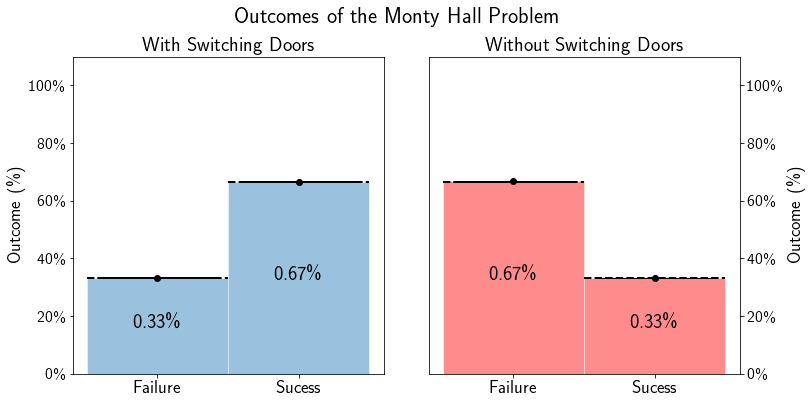

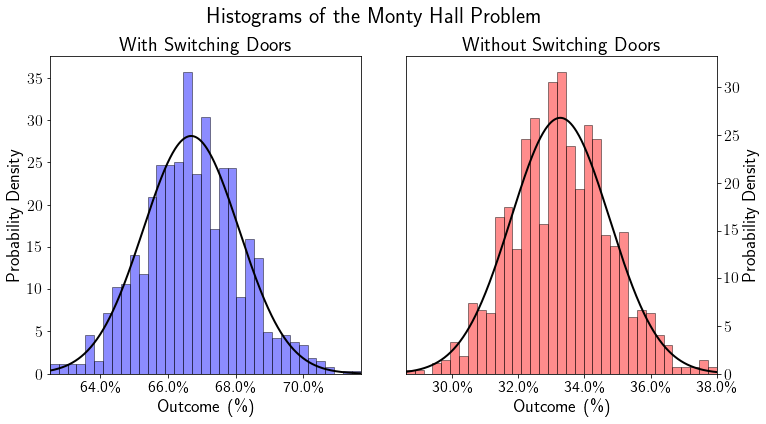

In [11]:
# runs the main function for 1000 trails (agents), 1000 samples, and default door configuration np.array([1,0,0])
main(1000,1000)

# runs the show_stat_fit function for 1000 trails (agents), 1000 samples, default door configuration, and uses 35 bins 
# in the histogram.
show_stat_fit(1000,1000,35)

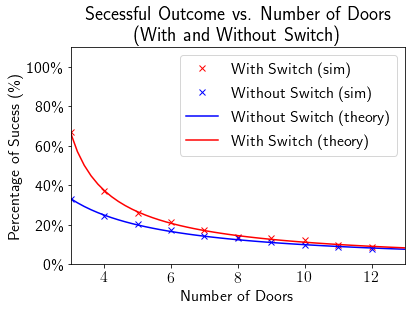

In [12]:
# runs trend_SinglePrize for 1000 trails (agents) and 10 samples, with a maximum of 13 doors.
trend_SinglePrize(1000,10,13)